In [1]:
# for testing whether CPU or GPU is faster on a problem
NO_GPU = False

if NO_GPU:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as kl
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build_model(*layers, verbose=False,
               optimizer='adam', loss='categorical_crossentropy', metrics=['acc'],
               compile_kwargs={}):
    
    model = keras.models.Sequential()
    
    for layer in layers:
        model.add(layer)
        
    if verbose:
        print("Model summary:")
        model.summary()
    
    for kw in ('optimizer', 'loss', 'metrics'):
        if not kw in compile_kwargs:
            compile_kwargs[kw] = locals()[kw]
    model.compile(**compile_kwargs)
    
    return model

In [3]:
def plot_history(history, figsize=(15,4), title='', columns=2, start_x_from=0):
    """Graphs a history for each key (combines validation and training keys into one plot).
    
    start_x_from=N skips the first N entries.
    
    History can be a whole training history class or just a dict."""
    
    if hasattr(history, 'history'): # full history given
        history = history.history   # only that history is enough
        
    assert hasattr(history, 'keys')
    keys = [key for key in history.keys() if not key.startswith("val_")]
    assert keys # there is one at least
    epochs = list(range(1,len(history[keys[0]])+1)) # all should have the same size list
    
    rows = np.ceil(len(keys)/columns).astype('int')
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    i = 1
    for key in sorted(keys):
        valkey = "val_" + key
        fig.add_subplot(rows, columns, i)
        i += 1
        plt.plot(epochs[start_x_from:], history[key][start_x_from:], label="Training " + key,
                 marker='.', color='#00A287', linestyle='')
        
        late_avg = np.mean(history[key][(len(history[key]) * 90) // 100 : ])
        plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                 color="#74E600", label='Mean {:.3f}'.format(late_avg))
        if valkey in history:
            plt.plot(epochs[start_x_from:], history[valkey][start_x_from:], label='Validation ' + key,
                    marker='+', color='#DF004F', linestyle='')
            
            late_avg = np.mean(history[valkey][(len(history[valkey]) * 90) // 100 : ])
            plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                     color="#FF6700", label='Mean {:.3f}'.format(late_avg))
        plt.legend()
        
    plt.show()

In [4]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data()

print("There are {} training samples and {} test samples".format(len(train_data), len(test_data)))

There are 8982 training samples and 2246 test samples


In [5]:
#  I wonder what lenghts do the sequences have, let's build a histogram

histogram_lengths = dict()
for sequence in train_data:
    seq_length = len(sequence)
    histogram_lengths[seq_length] = histogram_lengths.get(seq_length, 0) + 1

print("There are {} different lenghts of sequences".format(len(histogram_lengths)))

There are 698 different lenghts of sequences


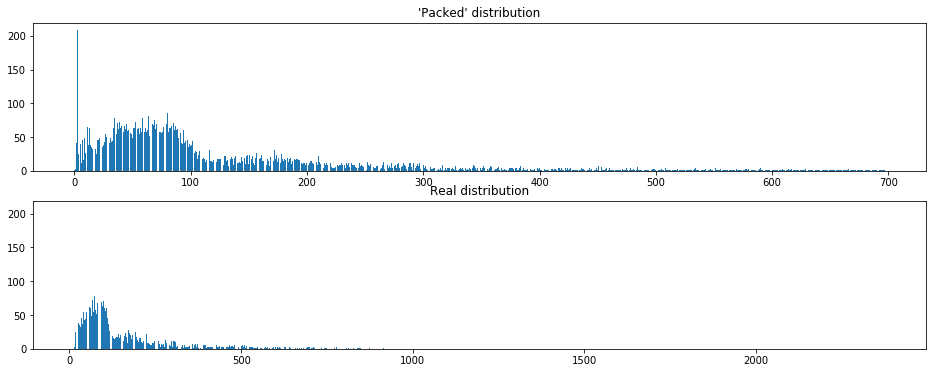

In [6]:
sortedkeys = sorted(histogram_lengths.keys())
plt.figure(figsize=(16,6))
plt.subplot(211)
plt.title("'Packed' distribution")
plt.bar(range(len(sortedkeys)), [histogram_lengths[k] for k in sortedkeys])
plt.subplot(212)
plt.title("Real distribution")
plt.bar(sortedkeys, [histogram_lengths[k] for k in sortedkeys])
plt.show()

In [7]:
# setting a threshold
MAX_SEQUENCE_LENGTH = 250

print("There are {} sequences having over {} words (out of {})".format(
    sum(map(histogram_lengths.get, filter(lambda x: MAX_SEQUENCE_LENGTH < x, sortedkeys))),
    MAX_SEQUENCE_LENGTH,
    len(train_data)
))

There are 1352 sequences having over 250 words (out of 8982)


In [8]:
histogram_words = dict()
total_words_count = 0
for sequence in train_data:
    for word in sequence:
        total_words_count += 1
        histogram_words[word] = histogram_words.get(word, 0) + 1 

word_frequencies = sorted(histogram_words.values(), reverse=1)

print("There are {} words, {} are unique".format(
    total_words_count,
    len(histogram_words),
))

There are 1307239 words, 28138 are unique


In [9]:
def print_occurences(dictionary_size):
    print("{:>9}  |  {:>6.2f}  |   {:>7}  |  {}".format(
        dictionary_size,
        sum(word_frequencies[:dictionary_size])*100.0/sum(word_frequencies),
        sum(word_frequencies[dictionary_size:]),
        word_frequencies[:dictionary_size][-1]
    ))
    
print("Dict. size | Covers % | Leaves out | Lowest word count")
for ds in list(range(1,21))+list(range(1000,30000,1000)):
    print_occurences(ds)

Dict. size | Covers % | Leaves out | Lowest word count
        1  |    5.04  |   1241290  |  65949
        2  |    7.63  |   1207499  |  33791
        3  |   10.10  |   1175237  |  32262
        4  |   12.11  |   1148928  |  26309
        5  |   13.94  |   1125071  |  23857
        6  |   15.76  |   1101230  |  23841
        7  |   17.57  |   1077620  |  23610
        8  |   18.78  |   1061797  |  15823
        9  |   19.80  |   1048457  |  13340
       10  |   20.72  |   1036435  |  12022
       11  |   21.63  |   1024534  |  11901
       12  |   22.44  |   1013838  |  10696
       13  |   23.20  |   1003899  |  9939
       14  |   23.89  |    994917  |  8982
       15  |   24.58  |    985971  |  8946
       16  |   25.25  |    977129  |  8842
       17  |   25.91  |    968561  |  8568
       18  |   26.55  |    960103  |  8458
       19  |   27.19  |    951767  |  8336
       20  |   27.76  |    944301  |  7466
     1000  |   78.32  |    283395  |  160
     2000  |   85.98  |    1833

In [10]:
DICTIONARY_SIZE = 4000 # number of the most common words to track of
SKIP_TOP_WORDS = 3      # number of the most common words to be skipped


(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
#    maxlen=MAX_SEQUENCE_LENGTH, # doing this in padding only?
    num_words=DICTIONARY_SIZE,
    skip_top=SKIP_TOP_WORDS
)

# first and last word is always the same in these sequences
#
# depending on type of padding one of them might be stripped in some cases
# so I tried to strip them from all sequences beforehands,
# unsurprisingly, no big differences were noticed (especially, when the
# trainings have too high variance and k-folding or longer training is
# not an option due to time...)
#train_data = np.array([s[:-1] for s in train_data])

print("Now there are {} training samples and {} test samples".format(len(train_data), len(test_data)))

# taken from the Chollet's original notebook
# to get a baseline for the current dictionary size and sequence length
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data, dimension=DICTIONARY_SIZE)
x_test = vectorize_sequences(test_data, dimension=DICTIONARY_SIZE)

train_data = pad_sequences(train_data, maxlen=MAX_SEQUENCE_LENGTH, truncating='post')
test_data  = pad_sequences(test_data, maxlen=MAX_SEQUENCE_LENGTH, truncating='post')

train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

Now there are 8982 training samples and 2246 test samples


Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                256064    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 46)                2990      
Total params: 263,214
Trainable params: 263,214
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 8982 samples, validate on 2246 samples
Epoch 1/20
8982/8982 [==============================] - 1s 

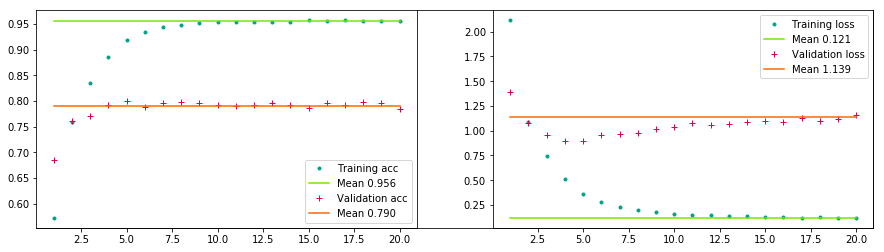

In [11]:
model_original = build_model(
    kl.InputLayer((DICTIONARY_SIZE,)),
    kl.Dense(64, activation='relu'),
    kl.Dense(64, activation='relu'),
    kl.Dense(46, activation='softmax'),
    verbose=1
)


history_original = model_original.fit(
    x_train,
    train_labels,
    epochs=20,
    batch_size=128,
    validation_data=(x_test, test_labels)
)

plot_history(history_original)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 32)           128000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 46)                368046    
Total params: 496,046
Trainable params: 496,046
Non-trainable params: 0
_________________________________________________________________
Train on 7185 samples, validate on 1797 samples
Epoch 1/20
7185/7185 [==============================] - 1s 88us/step - loss: 2.2552 - acc: 0.4075 - val_loss: 1.8421 - val_acc: 0.5170
Epoch 2/20
7185/7185 [==============================] - 0s 56us/step - loss: 1.5353 - acc: 0.6022 - val_loss: 1.4749 - val_acc: 0

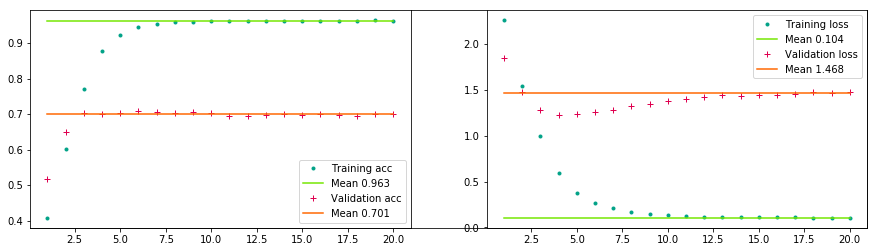

In [12]:
model_embedding_only = build_model(
    kl.Embedding(DICTIONARY_SIZE, 32, input_length=MAX_SEQUENCE_LENGTH),
    kl.Flatten(),
    kl.Dense(46, activation='softmax'),
    verbose=1
)


history_embedding_only = model_embedding_only.fit(
    train_data,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

plot_history(history_embedding_only)

It surprises me that I am getting about 70% accuracy - especially when the embedding layer retains the order of the sequence and does not just say which words appear there and which do not as in the original example.

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 32)           128000    
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 984       
_________________________________________________________________
dense_5 (Dense)              (None, 46)                414       
Total params: 129,398
Trainable params: 129,398
Non-trainable params: 0
_________________________________________________________________
Train on 7185 samples, validate on 1797 samples
Epoch 1/20
7185/7185 [==============================] - 24s 3ms/step - loss: 3.2850 - acc: 0.3478 - val_loss: 2.6487 - val_acc: 0.3450
Epoch 2/20
7185/7185 [==============================] - 23s 3ms/step - loss: 2.4883 - acc: 0.3534 - val_loss: 2.3639 - val_acc: 0.3450
Epoch 3/20
7185/7185 [==============================] - 23s 3ms/ste

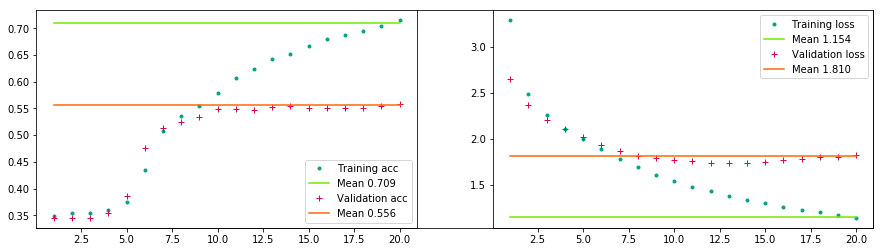

In [13]:
model_small = build_model(
    kl.Embedding(DICTIONARY_SIZE, 32, input_length=MAX_SEQUENCE_LENGTH),
    kl.GRU(8, return_sequences=False),
    kl.Dense(46, activation='softmax'),
    verbose=1
)

history_small = model_small.fit(
    train_data,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

plot_history(history_small)

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 32)           128000    
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_6 (Dense)              (None, 46)                2990      
Total params: 149,614
Trainable params: 149,614
Non-trainable params: 0
_________________________________________________________________
Train on 7185 samples, validate on 1797 samples
Epoch 1/40
7185/7185 [==============================] - 24s 3ms/step - loss: 2.6867 - acc: 0.3467 - val_loss: 2.1379 - val_acc: 0.3450
Epoch 2/40
7185/7185 [==============================] - 23s 3ms/step - loss: 2.0114 - acc: 0.3893 - val_loss: 1.9319 - val_acc: 0.4736
Epoch 3/40
7185/7185 [==============================] - 23s 3ms/ste

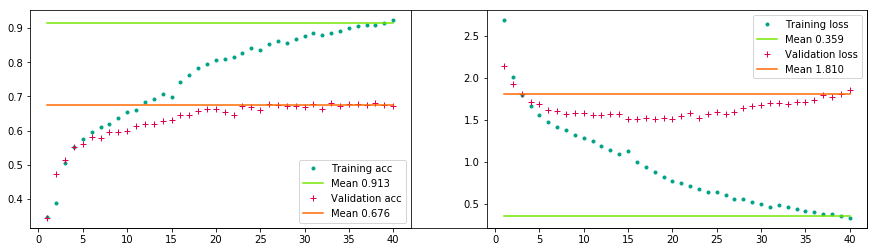

In [14]:
model_medium = build_model(
    kl.Embedding(DICTIONARY_SIZE, 32, input_length=MAX_SEQUENCE_LENGTH),
    kl.GRU(64, return_sequences=False),
    kl.Dense(46, activation='softmax'),
    verbose=1
)

history_medium = model_medium.fit(
    train_data,
    train_labels,
    epochs=40,
    batch_size=64,
    validation_split=0.2
)

plot_history(history_medium)

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 32)           128000    
_________________________________________________________________
gru_3 (GRU)                  (None, 250)               212250    
_________________________________________________________________
dense_7 (Dense)              (None, 46)                11546     
Total params: 351,796
Trainable params: 351,796
Non-trainable params: 0
_________________________________________________________________
Train on 7185 samples, validate on 1797 samples
Epoch 1/60
7185/7185 [==============================] - 24s 3ms/step - loss: 2.5219 - acc: 0.3506 - val_loss: 2.0455 - val_acc: 0.3506
Epoch 2/60
7185/7185 [==============================] - 24s 3ms/step - loss: 1.9245 - acc: 0.4598 - val_loss: 1.8169 - val_acc: 0.5042
Epoch 3/60
7185/7185 [==============================] - 24s 3ms/ste

7185/7185 [==============================] - 24s 3ms/step - loss: 0.0923 - acc: 0.9627 - val_loss: 1.8823 - val_acc: 0.7212
Epoch 56/60
7185/7185 [==============================] - 24s 3ms/step - loss: 0.0906 - acc: 0.9630 - val_loss: 1.9295 - val_acc: 0.7140
Epoch 57/60
7185/7185 [==============================] - 24s 3ms/step - loss: 0.0880 - acc: 0.9626 - val_loss: 1.8573 - val_acc: 0.7301
Epoch 58/60
7185/7185 [==============================] - 24s 3ms/step - loss: 0.0881 - acc: 0.9633 - val_loss: 1.9151 - val_acc: 0.7179
Epoch 59/60
7185/7185 [==============================] - 24s 3ms/step - loss: 0.0870 - acc: 0.9613 - val_loss: 1.9355 - val_acc: 0.7229
Epoch 60/60
7185/7185 [==============================] - 24s 3ms/step - loss: 0.0825 - acc: 0.9634 - val_loss: 1.9264 - val_acc: 0.7201


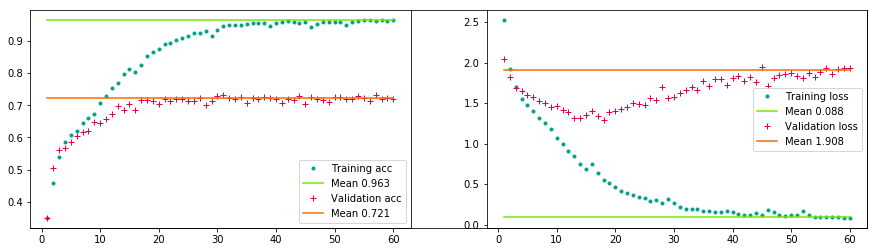

In [15]:
model_big = build_model(
    kl.Embedding(DICTIONARY_SIZE, 32, input_length=MAX_SEQUENCE_LENGTH),
    kl.GRU(MAX_SEQUENCE_LENGTH, return_sequences=False),
    kl.Dense(46, activation='softmax'),
    verbose=1
)

history_big = model_big.fit(
    train_data,
    train_labels,
    epochs=60,
    batch_size=64,
    validation_split=0.2
)

plot_history(history_big)

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 32)           128000    
_________________________________________________________________
gru_4 (GRU)                  (None, 250, 250)          212250    
_________________________________________________________________
gru_5 (GRU)                  (None, 250, 250)          375750    
_________________________________________________________________
gru_6 (GRU)                  (None, 250)               375750    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 125)               31375     
_________________________________________________________________
dense_9 (Dense)              (None, 46)                5796  

Epoch 51/100
8982/8982 [==============================] - 99s 11ms/step - loss: 0.2086 - acc: 0.9367 - val_loss: 1.7022 - val_acc: 0.7507
Epoch 52/100
8982/8982 [==============================] - 99s 11ms/step - loss: 0.2176 - acc: 0.9360 - val_loss: 1.6826 - val_acc: 0.7391
Epoch 53/100
8982/8982 [==============================] - 99s 11ms/step - loss: 0.2090 - acc: 0.9369 - val_loss: 1.6897 - val_acc: 0.7507
Epoch 54/100
8982/8982 [==============================] - 99s 11ms/step - loss: 0.2039 - acc: 0.9380 - val_loss: 1.7026 - val_acc: 0.7467
Epoch 55/100
8982/8982 [==============================] - 99s 11ms/step - loss: 0.2032 - acc: 0.9397 - val_loss: 1.6639 - val_acc: 0.7565
Epoch 56/100
8982/8982 [==============================] - 99s 11ms/step - loss: 0.2036 - acc: 0.9408 - val_loss: 1.7462 - val_acc: 0.7444
Epoch 57/100
8982/8982 [==============================] - 99s 11ms/step - loss: 0.1994 - acc: 0.9397 - val_loss: 1.6902 - val_acc: 0.7462
Epoch 58/100
8982/8982 [==========

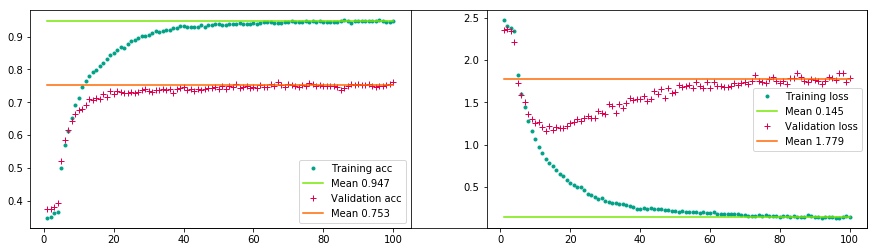

In [16]:
model_hopeful = build_model(
    kl.Embedding(DICTIONARY_SIZE, 32, input_length=MAX_SEQUENCE_LENGTH),
    kl.GRU(MAX_SEQUENCE_LENGTH, return_sequences=True,  dropout=0.18, recurrent_dropout=0.18),
    kl.GRU(MAX_SEQUENCE_LENGTH, return_sequences=True,  dropout=0.18, recurrent_dropout=0.18),
    kl.GRU(MAX_SEQUENCE_LENGTH, return_sequences=False, dropout=0.18, recurrent_dropout=0.18),
    kl.Dropout(0.2),
    kl.Dense(MAX_SEQUENCE_LENGTH // 2, activation='relu'),
    kl.Dense(46, activation='softmax'),
    verbose=1
)

history_hopeful = model_hopeful.fit(
    train_data,
    train_labels,
    epochs=100,
    batch_size=64,
    validation_data=(test_data, test_labels)
)

plot_history(history_hopeful)